## read the data

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import anndata

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

KeyboardInterrupt: 

In [1]:
adata = anndata.read_h5ad("../data/RNA/raw/test/tabula_sapiens_bone_marrow.h5ad")
adata

AnnData object with n_obs × n_vars = 35000 × 38030
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type', 

In [2]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [3]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 35000 × 38030
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type', 

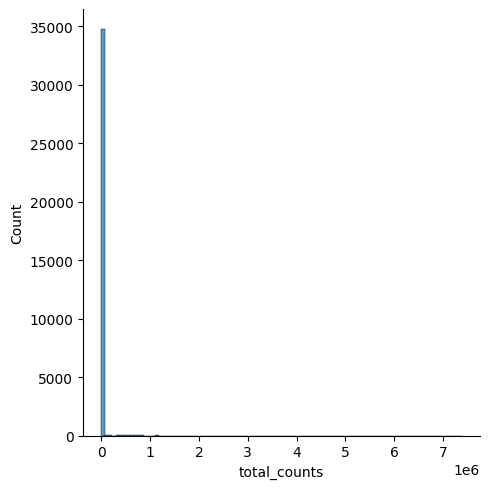

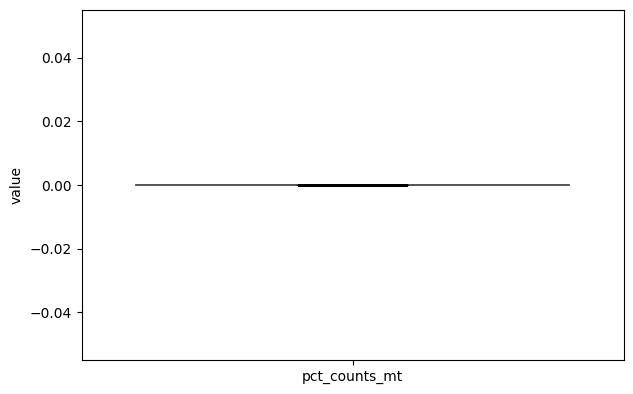

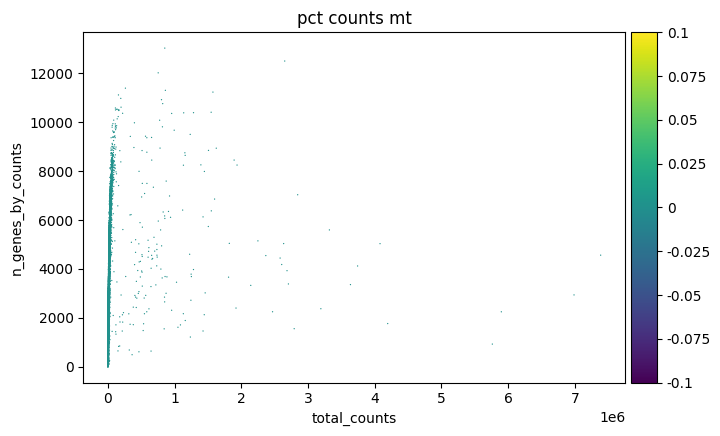

In [8]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [12]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    33896
True      1104
Name: count, dtype: int64

In [13]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    35000
Name: count, dtype: int64

In [14]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 35000
Number of cells after filtering of low quality cells: 33896


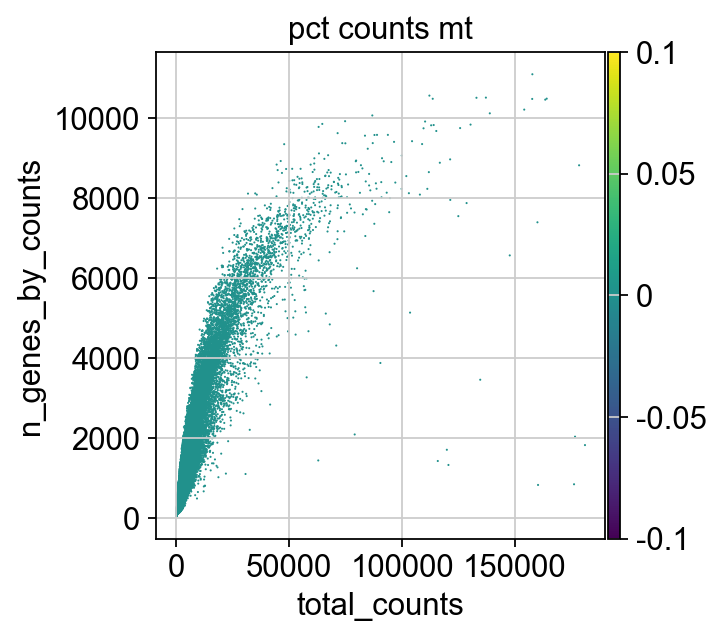

In [15]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [17]:
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/ipykernel_24388/3667344255.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [19]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [21]:
# Ensure adata_pp.X is float
if not np.issubdtype(adata.X.dtype, np.floating):
    adata.X = adata.X.astype(np.float32)  # or float64
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [24]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")
# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.
/var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/ipykernel_24388/523302931.py:3: FutureWarning: I

In [25]:
del adata_pp

In [26]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T